In [1]:
import os
import re
import sys
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import math
import pickle

# Image related imports
import av # TODO: Remove this after porting to PIL
from PIL import Image
# from resizeimage import resizeimage
from images2gif import writeGif

import matplotlib.pyplot as plt
import pickle

#import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
path_to_video = 'test.mp4'
data_dir = '../data'
images_dir = os.path.join(data_dir, 'frames_tmp_test/')
model_dir = '../imagenet/classify_image_graph_def.pb'
results_dir = '../results/'
cnn_diff_dir = os.path.join(results_dir, 'cnn_diff_tmp')
pixel_diff_dir = os.path.join(results_dir, 'pixel_diff_tmp')
out_dir = os.path.join(results_dir, 'combined_frames_tmp')
path_to_gif = '../gif'
path_to_gps = '../results/gps_out/gps_test.npy'
path_to_ground_truth = '../data/ground_truth/ground_truth_test.npy'
pickle_name = 'rahul1.pickle'
path_to_pixel_cnn_compare = os.path.join(results_dir,'pixel_cnn_compare/rahul1.png')
pickle_path = os.path.join(results_dir, pickle_name)

In [3]:
def frame_extractor(path_to_video, path_to_frames):
    container = av.open(path_to_video)
    video = next(s for s in container.streams if s.type == b'video')
    for packet in container.demux(video):
        for frame in packet.decode():
            frame.to_image().save(path_to_frames + '/frame-%06d.jpg' % frame.index)

In [4]:
class FeatureProcessor:
    def __init__(self, model_path, path_to_frames, change_points=5):
        self.model_path = model_path
        self.images_path = sorted([path_to_frames + f for f in os.listdir(path_to_frames) if re.search('jpg|JPG', f)])
        self.change_points = change_points
        #self.cnn_threshold = cnn_threshold
        #self.pixel_threshold = pixel_threshold 
        
    def create_graph(self):
        with gfile.FastGFile(self.model_path, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')
    
    def get_layer_list(self):
        self.create_graph()
        with tf.Session() as sess:
            operation_list = sess.graph.get_operations()
            for op in operation_list:
                print op.name
                print op.values().get_shape()

    # TODO: Experiment with other layers.            
    def extract_features(self, layer_name='pool_3:0', nb_features=2048):
        features = np.zeros((len(self.images_path), nb_features))
        labels = []
        self.create_graph()
        with tf.Session() as sess:
            next_to_last_tensor = sess.graph.get_tensor_by_name(layer_name)
            for index, image in enumerate(self.images_path):
                if (index % 100 == 0):
                    print('Processing %s...' % (image))
                if not gfile.Exists(image):
                    tf.logging.fatal('File does not exist %s', image)
                    continue
                image_data = gfile.FastGFile(image, 'rb').read()
                predictions = sess.run(next_to_last_tensor, {'DecodeJpeg/contents:0': image_data})
                features[index, :] = np.squeeze(predictions)
        return features
    
    def compute_change_points(self, distances):
        change_points = np.argpartition(-(distances/max(distances)),self.change_points)
        return np.sort(change_points[0:self.change_points]).tolist()
    
    @staticmethod
    def get_feature_differences(features):
        features_1 = features[:-1, :]
        features_2 = features[1:, :]
        saliency_matrix = features_2 - features_1

        differences = []
        for vector in saliency_matrix:
            differences.append(np.linalg.norm(vector))
        differences = np.asarray(differences)
        return differences, saliency_matrix

    def get_pixel_differences(self):
        prev_feature = np.array(Image.open(self.images_path[0])).flatten()
        nb_features = len(prev_feature.flatten())
        distances = []
        for index, next_path in enumerate(self.images_path[1:]):
                if (index % 100 == 0 and index > 0):
                    print('Processing Distance for %s...' % (next_path))
                next_feature = np.array(Image.open(next_path)).flatten()
                distances.append(np.linalg.norm(next_feature - prev_feature))
                prev_feature = next_feature
        return distances
    

In [5]:
class PlotterOut:
    def __init__(self,differences,frames_for_video=150):
        self.frames_for_video = frames_for_video
        self.start_frame = np.random.choice(len(differences)-self.frames_for_video-1,1)[0]
    
    def save_difference_plots(self,differences, path, color):
        # 5 = 120 pixels
        differences = differences[self.start_frame:self.start_frame+self.frames_for_video]
        differences = differences / max(differences)
        plt.rcParams['figure.figsize'] = (11.25, 3.75) 
        plt.figure()
        num_frames = len(differences)
        image_idx_list = range(self.start_frame, self.start_frame + self.frames_for_video)
        for (list_idx,i) in enumerate(image_idx_list):
            plot_file = os.path.join(path, '%06d.png' % i)
            plt.plot(differences[:list_idx+1], color=color)
            plt.xlim([0, num_frames])
            plt.ylim([0, 1])
            plt.savefig(plot_file)
            
    def combine_images(self):
        # plt.rcParams['figure.figsize'] = (10, 5)
        image_paths = sorted(os.listdir(images_dir))
        num_images = self.frames_for_video
        image_idx_list = range(self.start_frame, self.start_frame + self.frames_for_video)
        for (list_idx,i) in enumerate(image_idx_list):
            if list_idx % 50 == 0:
                print('Now processing', list_idx, 'out of', num_images)
            im_file = os.path.join(images_dir, image_paths[i])
            cnn_diff_file = os.path.join(cnn_diff_dir, '%06d.png' % i)
            pixel_diff_file = os.path.join(pixel_diff_dir, '%06d.png' % i)
            out_file = os.path.join(out_dir, '%06d.png' % i)
            cnn_diff_im = np.asarray(Image.open(cnn_diff_file))
            pixel_diff_im = np.asarray(Image.open(pixel_diff_file))
            diff_im = np.vstack([cnn_diff_im, pixel_diff_im])
            diff_im = diff_im[:,:,0:3]
            im = Image.open(im_file)
            im = im.resize((diff_im.shape[1],diff_im.shape[0]),Image.ANTIALIAS)
            im = np.asarray(im)
            combined = np.hstack([im, diff_im])
            combined_image = Image.fromarray(combined)
            #combined_image.show()
            combined_image.save(os.path.join(out_dir, '%06d.png' % list_idx), 'PNG')    
    
    @staticmethod
    def get_smoothed_list(list_to_smooth, window_size = 10):
        num_elements = len(list_to_smooth)
        smoothed_list = []
        cur_sum = sum(list_to_smooth[:window_size])
        smoothed_list.append(cur_sum * 1.0 / window_size)
        for i in xrange(window_size, num_elements):
            cur_sum -= list_to_smooth[i-window_size]
            cur_sum += list_to_smooth[i]
            smoothed_list.append(cur_sum * 1.0 / window_size)
        return smoothed_list
    
    @staticmethod
    def plot_differences(feature_differences, pixel_differences, path_to_pixel_cnn_compare):
        feature_differences = feature_differences / max(feature_differences)
        pixel_differences = pixel_differences / max(pixel_differences)
        plt.plot(feature_differences, label='Feature Differences')
        plt.plot(pixel_differences, label='Pixel Differences')
        plt.xlabel('Frame Index')
        plt.ylabel('Normalized Difference')
        plt.title('Comparison of Change Point between CNN and Raw Pixel')
        plt.legend()
        plt.savefig(path_to_pixel_cnn_compare)
        
    @staticmethod   
    def generate_gif(change_point_list, path_to_frames, path_to_gif):
        gif_list = []
        all_images_list = [path_to_frames + f for f in os.listdir(path_to_frames) if re.search('jpg|JPG', f)]
        gif_list_of_lists = [[change_point,change_point+(change_point_list[change_point_index+1]-change_point_list[change_point_index])/3,change_point+2*(change_point_list[change_point_index+1]-change_point_list[change_point_index])/3] for (change_point_index,change_point) in enumerate(change_point_list) if change_point_index<len(change_point_list)-1]
        for gif_segment in gif_list_of_lists:
            gif_list.extend(gif_segment)
        selected_gif_images = [Image.open(all_images_list[gif_points]) for gif_points in gif_list]
        writeGif(path_to_gif, selected_gif_images, duration=0.3, subRectangles=False)

In [6]:
class VideoLocChangePoint:
    def __init__(self,path_to_gps,feature_differences,change_points=1,fps=24):
        self.change_points = change_points
        self.fps = fps
        self.feature_differences = feature_differences/max(feature_differences)
        self.gps_stationary_intervals = np.load(path_to_gps).tolist()
        
    def get_motion_boundaries(self):
        boundaries = []
        for interval in self.gps_stationary_intervals:
            interval_multiplied = [val*self.fps for val in interval]
            boundaries.extend(interval_multiplied)
        return boundaries

    def get_top_k(self,start,end):
        differences = self.feature_differences[start:end+1]
        chosen = np.sort(np.argpartition(-differences,self.change_points)[0:self.change_points]).tolist()
        return chosen

    def merge_changepoints(self):
        boundaries = self.get_motion_boundaries()
        #adding last frame index
        boundaries.append(len(self.feature_differences)-1)
        changepoints = []
        start = 0
        for end in boundaries:
            indices_in_window = self.get_top_k(start,end)
            changepoints += [a+start for a in indices_in_window]
            start = end
        return changepoints

In [7]:
class EvaluationMetric:
    def __init__(self,path_to_ground_truth,error=5):
        self.ground_truth = np.load(path_to_ground_truth).tolist()
        #self.ground_truth = [0,1800,7632,11712,19872,22800,34656]
        self.error = error
        
    def compute_penalty(self,change_point_list):
        penalty = 0
        prev_partition_idx = 0
        for change_point in change_point_list:
            if prev_partition_idx == len(self.ground_truth)-1:
                break
            if change_point < self.ground_truth[prev_partition_idx]:
                continue
            if change_point >= self.ground_truth[prev_partition_idx] - self.error and change_point <= self.ground_truth[prev_partition_idx+1] + self.error:
                prev_partition_idx += 1
                continue
            if change_point >= self.ground_truth[prev_partition_idx + 1] + self.error:
                while(self.ground_truth[prev_partition_idx + 1] <= change_point):
                    penalty += (math.log(self.ground_truth[prev_partition_idx + 1] - self.ground_truth[prev_partition_idx]))/math.log(10)
                    prev_partition_idx += 1
                    if prev_partition_idx == len(self.ground_truth)-1:
                        break
        while(prev_partition_idx < len(self.ground_truth)-1):
            penalty += (math.log(self.ground_truth[prev_partition_idx + 1] - self.ground_truth[prev_partition_idx]))/math.log(10)
            prev_partition_idx += 1
        return penalty     

Processing ../data/frames_tmp_test/0000.jpg...
Processing ../data/frames_tmp_test/0100.jpg...
Processing ../data/frames_tmp_test/0200.jpg...
Processing ../data/frames_tmp_test/0300.jpg...
Processing ../data/frames_tmp_test/0400.jpg...
Processing ../data/frames_tmp_test/0500.jpg...
Processing Distance for ../data/frames_tmp_test/0101.jpg...
Processing Distance for ../data/frames_tmp_test/0201.jpg...
Processing Distance for ../data/frames_tmp_test/0301.jpg...
Processing Distance for ../data/frames_tmp_test/0401.jpg...
('Now processing', 0, 'out of', 150)
('Now processing', 50, 'out of', 150)
('Now processing', 100, 'out of', 150)


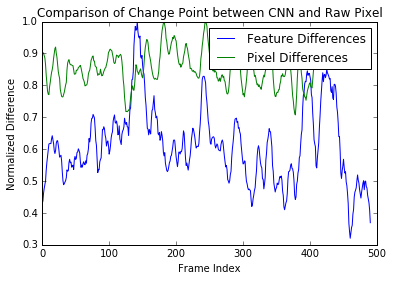

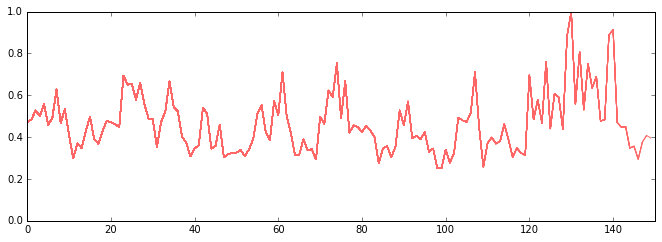

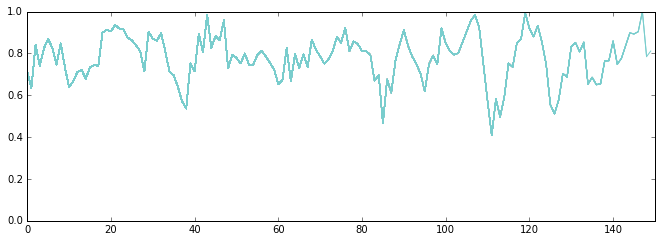

In [8]:
if __name__ == "__main__":
    
    # Feature Processor class to extract features from pre trained model
    feature_processor = FeatureProcessor(model_dir, images_dir)
    feature_processor.create_graph()
    features = feature_processor.extract_features()
    
    # Find differences using extracted features to identify saliency
    cnn_differences, saliency_matrix = feature_processor.get_feature_differences(features)
    
    # Find differences from raw pixels
    pixel_differences = feature_processor.get_pixel_differences()
    
    # Find change points from cnn and pixel
    cnn_change_points = feature_processor.compute_change_points(cnn_differences)
    pixel_change_points = feature_processor.compute_change_points(pixel_differences)
    
    # Use GPS sensor modality to find change points
    vid_gps_change_point = VideoLocChangePoint(path_to_gps,cnn_differences)
    vid_gps_changepoints = vid_gps_change_point.merge_changepoints()
    
    # Evaluation metric class. Find the penalty of each of the methods
    evaluation_metric = EvaluationMetric(path_to_ground_truth)
    cnn_penalty = evaluation_metric.compute_penalty(cnn_change_points)
    vid_gps_penalty = evaluation_metric.compute_penalty(vid_gps_changepoints)
    
    # Write to pickle file to save in case of failure in next steps
    with open(pickle_path,'w') as f:
        pickle.dump([cnn_differences,pixel_differences,cnn_change_points,pixel_change_points,vid_gps_changepoints,cnn_penalty,vid_gps_penalty],f)
    
    # Instantiate class to give plots, gif and video
    plotter_out = PlotterOut(cnn_differences)
    
    # Generate gif using cnn, pixel and video + gps
    plotter_out.generate_gif(cnn_change_points, images_dir, path_to_gif+'/cnn.gif')
    plotter_out.generate_gif(pixel_change_points, images_dir, path_to_gif+'/pixel.gif')
    plotter_out.generate_gif(vid_gps_changepoints, images_dir, path_to_gif+'/gps_vid.gif')
    
    # Plot the differences in saliency identified by cnn and features separately
    plotter_out.plot_differences(plotter_out.get_smoothed_list(cnn_differences), plotter_out.get_smoothed_list(pixel_differences),path_to_pixel_cnn_compare)
    
    # This is for generating video showing the cnn superiority over pixel differences.
    # Uncomment this for all but demo video sequence (200 frames at max)
    plotter_out.save_difference_plots(cnn_differences, cnn_diff_dir, '#ff6666')
    plotter_out.save_difference_plots(pixel_differences, pixel_diff_dir, '#79cdcd')
    plotter_out.combine_images()
    
    #Use this on command line to convert to video
    #ffmpeg -f image2 -r 24 -i %06d.png -vcodec mpeg4 -y movie.mp4

In [10]:
print vid_gps_changepoints
print cnn_change_points
print pixel_change_points

[15, 30, 57, 82, 146]
[142, 146, 399, 409, 445]
[148, 184, 200, 220, 246]


In [12]:
print cnn_penalty
print vid_gps_penalty

6.39040515648
2.72015930341
